In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Preprocessing
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# random
import random

# OrderedDict
from collections import OrderedDict

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
IMAGE_PATH = Path("/kaggle/input/api-rpd/Pest_V2")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg")) + list(IMAGE_PATH.glob("*/*.jpeg")) + list(IMAGE_PATH.glob("*/*.png"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')


Total Images = 3156


In [3]:
CLASSES = os.listdir(IMAGE_PATH)
CLASSES = sorted(CLASSES)

print("==" * 20)
print(" " * 10, f"Total Classes = {len(CLASSES)}")
print("==" * 20)

for label in CLASSES:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpeg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.png"))
    print(f'* {label}: {len(total_images_class)} images')


           Total Classes = 10
* asiatic rice borer: 498 images
* brown plant hopper: 346 images
* paddy stem maggot: 89 images
* rice gall midge: 217 images
* rice leaf caterpillar: 153 images
* rice leaf roller: 716 images
* rice leafhopper: 244 images
* rice water weevil: 414 images
* small brown plant hopper: 243 images
* yellow rice borer: 236 images


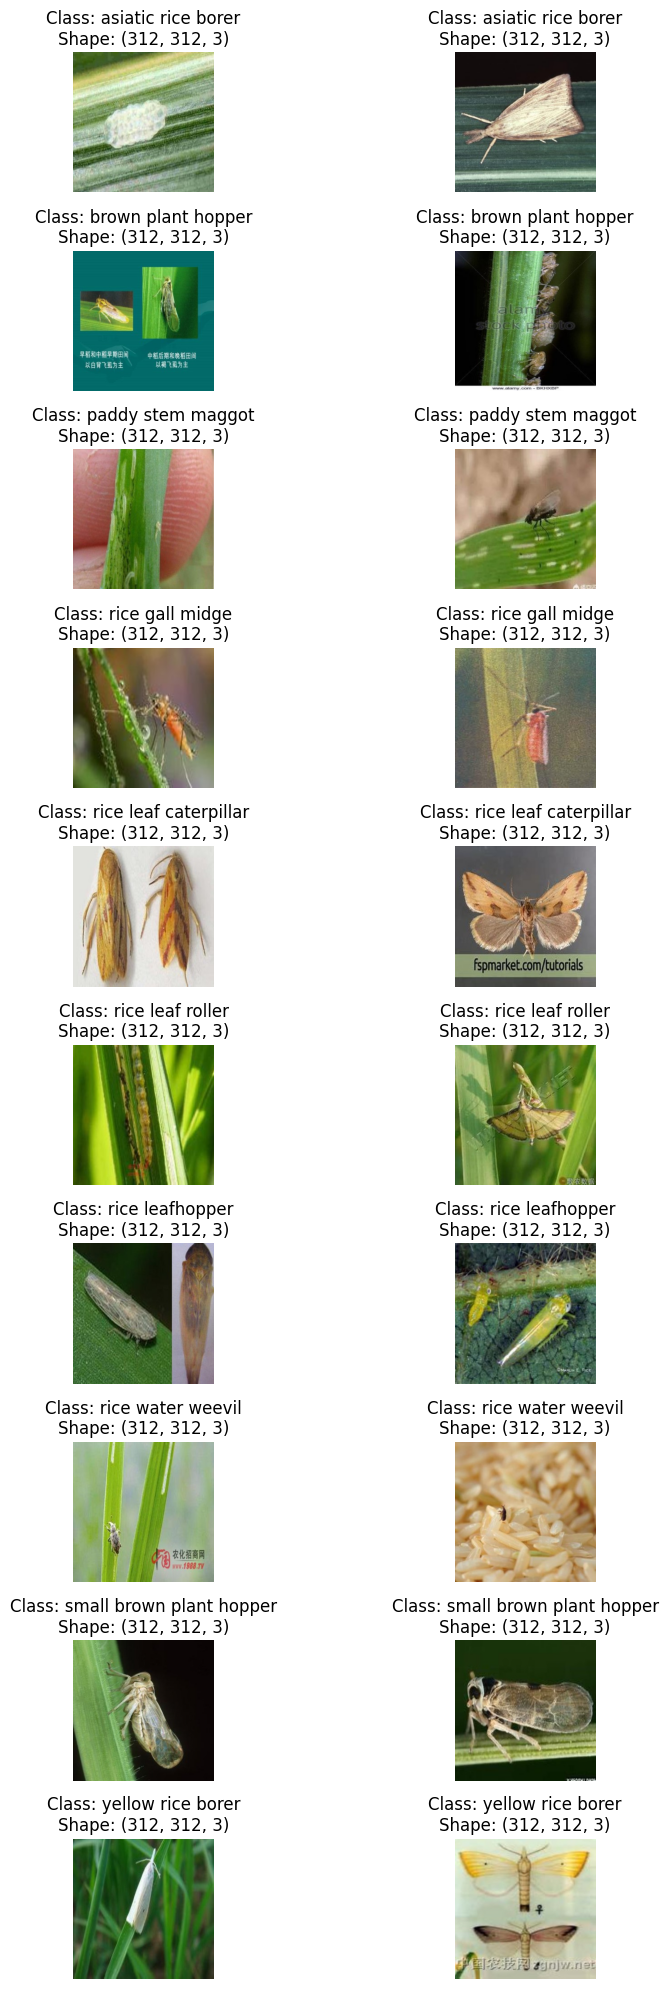

In [4]:
NUM_IMAGES = 2

fig, ax = plt.subplots(nrows = len(CLASSES), 
                       ncols = NUM_IMAGES, 
                       figsize = (10,20))

p = 0

for label in CLASSES:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpeg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.png"))
    total_images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(total_images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis('off')
        ax[p,i].set_title(f'Class: {label}\nShape: {img_rgb.shape}')
        
    p += 1
    
fig.tight_layout()
fig.show()

In [5]:
image_paths = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    image_paths[i] = img_path
    labels[i] = img_path.parent.stem
    
data = pd.DataFrame({'Image':image_paths, 'Label':labels})
data.head()

,Image,Label
0,/kaggle/input/api-rpd/Pest_V2/paddy stem maggo...,paddy stem maggot
1,/kaggle/input/api-rpd/Pest_V2/paddy stem maggo...,paddy stem maggot
2,/kaggle/input/api-rpd/Pest_V2/paddy stem maggo...,paddy stem maggot
3,/kaggle/input/api-rpd/Pest_V2/paddy stem maggo...,paddy stem maggot
4,/kaggle/input/api-rpd/Pest_V2/paddy stem maggo...,paddy stem maggot


In [6]:
# We are going to perform bootstrap sampling to increase the number of images.
SEED = 42

num_samples = 3
new_output = [None] * num_samples

for i,sample in enumerate(range(num_samples)):
    new_output[i] = data.sample(n = len(data), replace = True, random_state = SEED)
    
data_new = pd.concat((new_output), ignore_index = True)
data_new.head()

,Image,Label
0,/kaggle/input/api-rpd/Pest_V2/brown plant hopp...,brown plant hopper
1,/kaggle/input/api-rpd/Pest_V2/rice water weevi...,rice water weevil
2,/kaggle/input/api-rpd/Pest_V2/small brown plan...,small brown plant hopper
3,/kaggle/input/api-rpd/Pest_V2/small brown plan...,small brown plant hopper
4,/kaggle/input/api-rpd/Pest_V2/rice leaf roller...,rice leaf roller


In [7]:
data_new['Label'].value_counts()

Label
rice leaf roller            2196
asiatic rice borer          1464
rice water weevil           1233
brown plant hopper          1068
small brown plant hopper     726
yellow rice borer            684
rice gall midge              660
rice leafhopper              645
rice leaf caterpillar        507
paddy stem maggot            285
Name: count, dtype: int64

In [8]:
data_train, data_rest = train_test_split(data_new, 
                                         test_size = 0.3, 
                                         random_state = SEED, 
                                         stratify = data_new['Label'])

data_val, data_test = train_test_split(data_rest, 
                                       test_size = 0.5, 
                                       random_state = SEED, 
                                       stratify = data_rest['Label'])

In [9]:
# Let's define a dictionary to map the labels and convert them to numbers.
label2id = dict(zip(CLASSES, range(len(CLASSES))))
label2id

{'asiatic rice borer': 0,
 'brown plant hopper': 1,
 'paddy stem maggot': 2,
 'rice gall midge': 3,
 'rice leaf caterpillar': 4,
 'rice leaf roller': 5,
 'rice leafhopper': 6,
 'rice water weevil': 7,
 'small brown plant hopper': 8,
 'yellow rice borer': 9}

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, data:pd.DataFrame, 
                 transforms, 
                 label2id:dict):
        
        self.data = data
        self.transforms = transforms
        self.label2id = label2id
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_new = self.data.copy()
        data_new['Label'] = data_new['Label'].map(self.label2id)
        
        # Image
        image_path = data_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        
        # Target
        target = data_new.iloc[idx, 1]
        
        return image, target

In [11]:
from torchvision.models import densenet169,DenseNet169_Weights

In [12]:
# We are going to use the transformations that are applied to the images for pre-training.
weights = DenseNet169_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
train_dataset = CustomImageDataset(data_train, auto_transforms, label2id)

val_dataset = CustomImageDataset(data_val, auto_transforms, label2id)

In [14]:
BATCH_SIZE = 48

NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS)

In [15]:
# We visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([48, 3, 224, 224]), torch.Size([48]))

In [16]:
# GPU
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
DEVICE

'cuda'

In [17]:
# Define model
model = densenet169(weights = weights)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 154MB/s]


In [18]:
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])

Layer (type (var_name))                       Input Shape       Output Shape      Param #           Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224] [32, 1000]        --                True
├─Sequential (features)                       [32, 3, 224, 224] [32, 1664, 7, 7]  --                True
│    └─Conv2d (conv0)                         [32, 3, 224, 224] [32, 64, 112, 112] 9,408             True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112] [32, 64, 112, 112] 128               True
│    └─ReLU (relu0)                           [32, 64, 112, 112] [32, 64, 112, 112] --                --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112] [32, 64, 56, 56]  --                --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]  [32, 256, 56, 56] --                True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]  [32, 32, 56, 56]  45,440            True
│    │    └─_DenseLayer (denselayer2)         [3

In [19]:
output_shape = len(CLASSES)
model.fc = nn.Linear(in_features = 2048, out_features = output_shape)

In [20]:
# We last view our model to check if the last layer was modified.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])

Layer (type (var_name))                       Input Shape       Output Shape      Param #           Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224] [32, 1000]        20,490            True
├─Sequential (features)                       [32, 3, 224, 224] [32, 1664, 7, 7]  --                True
│    └─Conv2d (conv0)                         [32, 3, 224, 224] [32, 64, 112, 112] 9,408             True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112] [32, 64, 112, 112] 128               True
│    └─ReLU (relu0)                           [32, 64, 112, 112] [32, 64, 112, 112] --                --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112] [32, 64, 56, 56]  --                --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]  [32, 256, 56, 56] --                True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]  [32, 32, 56, 56]  45,440            True
│    │    └─_DenseLayer (denselayer2)         [3

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

In [22]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [23]:
early_stopping = EarlyStopping(patience = 10, delta = 0.)

In [24]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0
    train_accuracy = 0
    
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)
        
        optimizer.zero_grad()
        
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = y_pred_logit.softmax(dim = 1)
        y_pred_class = y_pred_prob.argmax(dim = 1)
        
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [25]:
def val_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
             loss_fn:torch.nn.Module):
    
    model.eval()
    
    val_loss = 0
    val_accuracy = 0
    
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)

            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            val_loss += loss.item()

            y_pred_prob = y_pred_logit.softmax(dim = 1)
            y_pred_class = y_pred_prob.argmax(dim = 1)

            val_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
        
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    
    return val_loss, val_accuracy

In [26]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, 
          early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        val_loss, val_accuracy = val_step(model = model, 
                                          dataloader = val_dataloader, 
                                          loss_fn = loss_fn)
        
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train Accuracy: {train_accuracy:.4f} | ', 
              f'Val Loss: {val_loss:.4f} | ', 
              f'Val Accuracy: {val_accuracy:.4f}')
        
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['val_loss'].append(val_loss)
        results['val_accuracy'].append(val_accuracy)
        
    return results

In [27]:
# Training!!!
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 2.6875 |  Train Accuracy: 0.2226 |  Val Loss: 4618.5992 |  Val Accuracy: 0.1839
Epoch: 2 |  Train Loss: 2.2128 |  Train Accuracy: 0.2582 |  Val Loss: 5.5928 |  Val Accuracy: 0.2762
Epoch: 3 |  Train Loss: 2.1194 |  Train Accuracy: 0.2813 |  Val Loss: 2.3279 |  Val Accuracy: 0.2837
Epoch: 4 |  Train Loss: 2.0567 |  Train Accuracy: 0.3005 |  Val Loss: 2.0504 |  Val Accuracy: 0.3083
Epoch: 5 |  Train Loss: 1.8539 |  Train Accuracy: 0.3704 |  Val Loss: 2.0822 |  Val Accuracy: 0.3031
Epoch: 6 |  Train Loss: 1.7581 |  Train Accuracy: 0.4041 |  Val Loss: 1.7930 |  Val Accuracy: 0.3850
Epoch: 7 |  Train Loss: 1.6284 |  Train Accuracy: 0.4529 |  Val Loss: 1.7843 |  Val Accuracy: 0.4165
Epoch: 8 |  Train Loss: 1.5157 |  Train Accuracy: 0.4892 |  Val Loss: 1.8274 |  Val Accuracy: 0.4654
Epoch: 9 |  Train Loss: 1.4238 |  Train Accuracy: 0.5279 |  Val Loss: 1.7591 |  Val Accuracy: 0.4294
Epoch: 10 |  Train Loss: 1.4267 |  Train Accuracy: 0.5255 |  Val Loss: 1.5244 |  Val Acc

In [28]:
# We define a function to visualize the evolution of the metric and the loss during training.
def loss_and_metric_plot(results:dict):
    training_loss = results['train_loss']
    valid_loss = results['val_loss']
    
    training_accuracy = results['train_accuracy']
    valid_accuracy = results['val_accuracy']
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    axes = axes.flat
    
    axes[0].plot(range(len(training_loss)), training_loss)
    axes[0].plot(range(len(valid_loss)), valid_loss)
    axes[0].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_title("CrossEntropyLoss", fontsize = 14, fontweight = "bold", color = "blue")
    
    axes[1].plot(range(len(training_accuracy)), training_accuracy)
    axes[1].plot(range(len(valid_accuracy)), valid_accuracy)
    axes[1].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_ylabel("score", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_title("Accuracy", fontsize = 14, fontweight = "bold", color = "red")
    
    fig.tight_layout()
    fig.show()

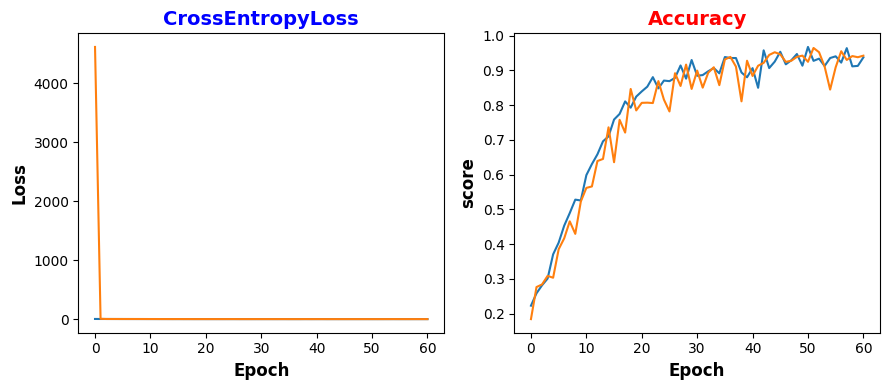

In [29]:
loss_and_metric_plot(RESULTS)

In [30]:
def predictions(test_dataloader:torch.utils.data.DataLoader, best_model:str):
    
    checkpoint = torch.load(best_model)
    
    loaded_model = densenet169()
    
    loaded_model.fc = nn.Linear(in_features = 2048,  out_features = output_shape)

    loaded_model.load_state_dict(checkpoint)
    
    loaded_model.to(device = DEVICE)
    
    loaded_model.eval()
    
    y_pred_test = []
    
    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y_pred_logit = loaded_model(X)
            y_pred_prob = y_pred_logit.softmax(dim = 1)
            y_pred_class = y_pred_prob.argmax(dim = 1)
            y_pred_test.append(y_pred_class.detach().cpu())
            
    y_pred_test = torch.cat(y_pred_test)
    
    return y_pred_test

In [31]:
# We create our Dataset and DataLoader for our test set.
test_dataset = CustomImageDataset(data_test,auto_transforms, label2id)
test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS)

In [32]:
# We make the predictions.
y_pred_test = predictions(test_dataloader, "/kaggle/working/best_model.pth")

  0%|          | 0/30 [00:00<?, ?it/s]

In [33]:
test_accuracy = accuracy_score(data_test['Label'].map(label2id), y_pred_test.numpy())

print(f"Accuracy Test = {test_accuracy:.4f}")

Accuracy Test = 0.9620


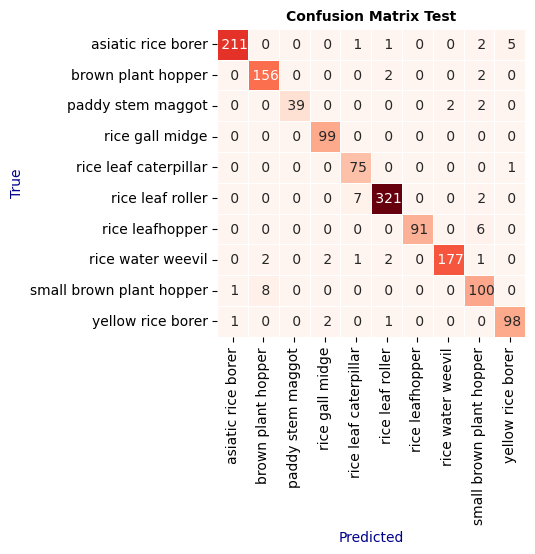

In [34]:
cf_mx_test = confusion_matrix(data_test['Label'].map(label2id), y_pred_test.numpy())

fig,ax = plt.subplots(figsize = (9,4))
sns.heatmap(cf_mx_test, cmap = 'Reds', fmt = ' ', annot = True, cbar = False, square = True, linewidths = 0.4,
            xticklabels = CLASSES, yticklabels = CLASSES, ax = ax)
ax.set_ylabel("True", color = "darkblue")
ax.set_xlabel("Predicted", color = "darkblue")
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "black")

fig.show()